# Предсказание ожидаемой продолжительности жизни в странах

In [11]:
import sys
# Добавим папку с корнем проекта в список системных директорий, чтобы Python видел путь к папке utils
sys.path.append('..')

In [12]:
from IPython.display import Markdown
import time
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import (
    MinMaxScaler, 
    PolynomialFeatures, 
    OneHotEncoder,
)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import (
    BaggingRegressor, 
    AdaBoostRegressor,
    StackingRegressor,
)
import category_encoders as ce

from utils.constants import (
    F, 
    RANDOM_STATE,
)
from utils.helpers import get_exec_time
from utils.display_content import (
    display_fields_correlation,
)
from utils.prepare_data import (
    get_location_codes,
    get_location_time_series,
    get_location_by_code,
    get_train_test_data,
    get_data_with_smoothing_target_feature,
    get_integration_order,
    get_predictors,
    get_train_test_split,
    get_location_data,
    get_formatted_time_series,
)
from classes.LocationCluster import LocationCluster
from classes.LocationCoef import LocationCoef

%matplotlib inline

from warnings import simplefilter
simplefilter('ignore')

In [13]:
# Загрузим таблицу
data_source = pd.read_csv(
    '../data/cumulative_life_expectancy_prepared.csv'
)

data_source.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,27.56,41.14,2.74,1.11,7.66,563.733796,16194869.0,5.027188,28.000000,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,28.99,42.25,5.97,2.05,13.35,533.586202,16747208.0,5.092250,43.333333,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,30.42,43.38,4.19,1.31,11.54,882.147847,17327699.0,5.157312,42.666667,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,31.86,44.36,4.26,1.47,14.55,992.698979,17943712.0,5.222375,37.000000,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,33.29,45.35,5.66,1.69,21.36,1266.210864,18600423.0,5.287437,36.000000,52.36


In [14]:
# Загрузим также таблицу с порядком интегрирования рядов стран
integration_order_data = pd.read_csv(
    '../data/integration_order.csv'
)

integration_order_data.head()

,SpatialDimValueCode,IntegrationOrder
0,AGO,1
1,BDI,1
2,BEN,1
3,BFA,1
4,BWA,1


## Выбор метрики MAE

Поскольку мы решаем задачу регрессии (предсказываем число), выберем в качестве метрики \
среднюю абсолютную ошибку для полученного прогноза — MAE (Mean Absolute Error),

$$ MAE = \frac{\sum_{i=1}^{n}\left | y_{i} - \hat{y_{i}} \right |}{n} $$

In [15]:
# Словарь для хранения метрик, полученных с помощью разных моделей
model_results = {}


def save_model_result(
    model_name: str, 
    mae_test: float,
    mae_train: float,
    model_fit_time: str
) -> None:
    """Сохраняет значение метрики и время обучения для переданной модели

    Args:
        model_name (str): имя модели
        mae_test (float): метрика MAE для тестовой выборки
        mae_train (float): метрика MAE для тренировочной выборки
        model_fit_time (str): время обучения модели
    """
    model_results[model_name] = { 
        'MaeTest': mae_test, 'MaeTrain': mae_train, 'ModelFitTime': model_fit_time,
    }
    
    
def display_model_results(should_sorted: bool = False) -> None:
    """Выводит таблицу со значениями метрики MAE и временем обучения для разных моделей
    
    Args: 
        should_sorted (bool, optional): нужно ли сорртировать строки по возрастанию метрики
            По умолчанию False
    """
    display(Markdown('**Значения метрики MAE для разных моделей**'))
    
    model_results_data = pd.DataFrame(model_results).transpose()
    
    if (should_sorted):
        display(model_results_data.sort_values(by=['MaeTest', 'MaeTrain']))
    else:
        display(model_results_data)

## Разделение данных на обучающую и тестовую выборки

Поскольку данные продолжительности жизни для стран за 2000 - 2020 гг являются временными рядами \
и имеет смысл предсказание будущих значений, \
то в качестве тестовой выборки отделим последние 3 года, то есть с 2018 по 2020 гг.

In [16]:
# Разделим данные на тренировочные и тестовые
train_data_source, test_data_source = get_train_test_data(data_source)

display(train_data_source.head(3))
display(test_data_source.head(3))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,27.56,41.14,2.74,1.11,7.66,563.733796,16194869.0,5.027188,28.000000,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,28.99,42.25,5.97,2.05,13.35,533.586202,16747208.0,5.092250,43.333333,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,30.42,43.38,4.19,1.31,11.54,882.147847,17327699.0,5.157312,42.666667,51.06


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,LifeExpectancy
18,AFR,Africa,AGO,Angola,2018,25.83,0.009380,0.233096,24.0,0.013602,...,51.12,56.59,5.36,1.10,35.75,2538.591391,31297155.0,6.377063,58.000000,62.27
19,AFR,Africa,AGO,Angola,2019,25.79,0.009200,0.227687,24.6,0.013479,...,51.39,56.88,5.51,1.12,29.33,2189.855714,32375632.0,6.488062,54.666667,62.49
20,AFR,Africa,AGO,Angola,2020,25.54,0.009377,0.221906,25.3,0.012816,...,51.66,57.17,7.31,1.70,29.04,1449.922867,33451132.0,6.599062,48.666667,62.65


Добавим столбец `SmoothingLifeExpectancy` со сглаженными значениями и прогнозом в тренировочные и тестовые данные.

In [17]:
# Начинаем замерять время выполнения
start = time.time()

train_data, test_data = get_data_with_smoothing_target_feature(
    train_data_source, test_data_source
)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

## Прогноз на основе экспоненциального сглаживания

Посмотрим, какое значение метрики даст уже добавленный признак `SmoothingLifeExpectancy`, \
полученный с помощью экспоненциального сглаживания.\
Его ведь уже можно считать предсказанием.

In [18]:
# Истинные значения тестовой выборки
y_test = test_data[F.LifeExpectancy.value]
# Сглаженные значения прогноза на 3 года
y_test_pred = test_data[F.SmoothingLifeExpectancy.value]

# Истинные значения тренировочной выборки
y_train = train_data[F.LifeExpectancy.value]
# Сглаженные значения тренировочной выборки
y_train_pred = train_data[F.SmoothingLifeExpectancy.value]

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)
# Метрика MAE для тренировочной выборки
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'ExponentialSmoothing',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01


То есть, в среднем полученный пока прогноз ошибается на 0.554 года.

## ARIMA

**ARIMA** расшифровывается как **Autoregressive Integrated Moving Average** \
(Авторегрессионное интегрированное скользящее среднее)\
И включает в себя 3 параметра:

- `p` — параметр авторегрессионной модели (`AR(p)`), \
количество авторегрессионных слагаемых, \
определяется по графику частичной автокорреляции;
- `q` — параметр скользящего среднего (`MA(q)`), \
количество слагаемых скользящего среднего шумовой компоненты, \
определяется по графику автокорреляции.
- `d` — порядок дифференцирования ряда.

Значение `d` определим по ранее созданной [здесь](../03_eda/09_stationarity.ipynb) таблице `integration_order.csv`\
с помощью функции `get_integration_order` из файла [prepare_data.py](../utils/prepare_data.py)

А значения `p` и `q` возьмем равными `1`, так как по графикам автокорреляции и частичной автокорреляции,\
построенными в файле [11_partial_autocorrelation.ipynb](../03_eda/11_partial_autocorrelation.ipynb)
полноценно закономерность на таком небольшом количестве данных мы не уловим.

In [19]:
# Коды всех стран
location_codes = get_location_codes(data_source)

# Таблица, в которую будем собирать данные прогнозов по странам
forecast_test_data = pd.DataFrame(
    columns=[F.SpatialDimValueCode.value, F.Period.value, F.LifeExpectancy.value]
)
# Таблица, в которую будем собирать тренировочные данные (для подсчета тренировочной метрики)
forecast_train_data = pd.DataFrame(
    columns=[F.SpatialDimValueCode.value, F.Period.value, F.LifeExpectancy.value]
)

# Начинаем замерять время выполнения
start = time.time()

# Посчитаем прогноз для каждой страны
for code in location_codes:
    # Временной ряд для тренировочных данных
    location_time_series_train = get_location_time_series(train_data, code) 
    # Временной ряд для тестовых данных
    location_time_series_test = get_location_time_series(test_data, code) 
    # Количество значений, которые нужно предсказать
    predict_length = len(location_time_series_test)
    # Порядок интегрирования ряда для данной страны
    integration_order = get_integration_order(code)
    # Параметры модели
    p = 1
    q = 1
    d = integration_order
    # Создаем объект модели
    arima_model = ARIMA(location_time_series_train, order=(p, d, q))
    # Обучим модель
    arima_model_fit = arima_model.fit()
    # Получим прогноз на то же количество лет, которое содержится в тестовом временном ряду
    forecast = arima_model_fit.forecast(predict_length)
    
    # Соберем данные прогноза по стране в таблицу
    location_forecast_test_data = pd.DataFrame({
        F.SpatialDimValueCode.value: code,
        F.Period.value: forecast.index, 
        F.LifeExpectancy.value: forecast.values,
    })
    # Присоединим ее к общей таблице прогнозов
    forecast_test_data = pd.concat([forecast_test_data, location_forecast_test_data], ignore_index=True)
    
    # Соберем тренировочные данные по стране в таблицу
    location_forecast_train_data = pd.DataFrame({
        F.SpatialDimValueCode.value: code,
        F.Period.value: arima_model_fit.fittedvalues.index, 
        F.LifeExpectancy.value: arima_model_fit.fittedvalues.values,
    })
    # Присоединим ее к общей таблице тренировочных данны
    forecast_train_data = pd.concat([forecast_train_data, location_forecast_train_data], ignore_index=True)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Поля для сортировки
sort_fields = [F.SpatialDimValueCode.value, F.Period.value]

# Истинные значения тестовой выборки
y_test = test_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]
# Значения прогноза 
y_test_pred = forecast_test_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]

# Истинные значения тренировочной выборки
y_train = train_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]
# Тренировочные значения модели
y_train_pred = forecast_train_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)
# Метрика MAE для тренировочной выборки
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'ARIMA',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11


`ARIMA` первым тренировочным значением берет 0, поэтому значение тренировочной метрики большое.

Попробуем воспользоваться библиотекой `pmdarima` для подбора параметров модели `ARIMA`.

In [20]:
# Таблица, в которую будем собирать данные прогнозов по странам
forecast_data = pd.DataFrame(
    columns=[F.SpatialDimValueCode.value, F.Period.value, F.LifeExpectancy.value]
)

# Начинаем замерять время выполнения
start = time.time()

# Посчитаем прогноз для каждой страны
for code in location_codes:
    # Временной ряд для тренировочных данных
    location_time_series_train = get_location_time_series(train_data, code) 
    # Временной ряд для тестовых данных
    location_time_series_test = get_location_time_series(test_data, code) 
    # Количество значений, которые нужно предсказать
    predict_length = len(location_time_series_test)
    
    # Инициализируем объект pmdarima для подбора параметров
    pm_auto_arima_model = pm.auto_arima(
        location_time_series_train,
        start_p=1, start_q=1, # начальные значения для p и q
        max_p=2, max_q=2, # максимальные значения для p и q
        max_d=3, # максимальное значение d
        seasonal=False, # сезонности у нас нет
        test='kpss', # тест возьмем тот же, которым ранее определяли стационарность ряда
    )
    # Получим прогноз
    forecast = pm_auto_arima_model.fit_predict(location_time_series_train, n_periods=predict_length)
    
    # Соберем данные прогноза по стране в таблицу
    location_forecast_data = pd.DataFrame({
        F.SpatialDimValueCode.value: code,
        F.Period.value: forecast.index, 
        F.LifeExpectancy.value: forecast.values,
    })
    # Присоединим ее к общей таблице прогнозов
    forecast_data = pd.concat([forecast_data, location_forecast_data], ignore_index=True)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Истинные значения тестовой выборки
y_test = test_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]
# Значения прогноза 
y_test_pred = forecast_data.sort_values(by=sort_fields)[F.LifeExpectancy.value]

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'ARIMA with pmdarima',
    mae_test,
    # Не будем считать в данном случае тренировочную метрику, так как ценной информации она не даст
    None, 
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07


Метрика не улучшилась, а время выполнения дольше, чем для экспоненциального сглаживания.\
Скорее всего, модель ARIMA подходит хуже из-за небольшого количества данных в рядах.

## ARIMAX

Для предсказания значений временного ряда с экзогенными переменными используем модель `ARIMAX`.\
Модель `SARIMAX` из библиотеки `statsmodels` без использования сезонной составляющей даст в итоге модель `ARIMAX`.\
То есть, мы не будем указывать параметр `seasonal_order` для модели `SARIMAX`.

In [21]:
# Таблица, в которую будем собирать данные прогнозов по странам
forecast_data = pd.DataFrame(
    columns=[F.SpatialDimValueCode.value, F.Period.value, F.LifeExpectancy.value]
)

# Первый и последний год в исходной таблице
year_start = data_source[F.Period.value].min()
year_end = data_source[F.Period.value].max()

# Начинаем замерять время выполнения
start = time.time()

# Составим прогноз для каждой страны
for code in location_codes:
    # Название страны
    location = get_location_by_code(code)    
    # Данные страны
    location_data = get_location_data(data_source, code)
    
    # Получаем тренировочные и тестовые данные для страны
    X_train, X_test, y_train, y_test = get_train_test_split(
        location_data,
        should_include_time_feature = False,
    )
    
    # Длина ряда с пронозом
    predict_length = len(y_test)
    
    # Порядок интегрирования ряда
    integration_order = get_integration_order(code)
    # Параметры order
    p = 1
    q = 1
    d = integration_order
    
    # Объект модели SARIMAX
    sarimax_model = SARIMAX(
        y_train, # Временной ряд
        X_train, # Экзогенные параметры
        order=(p, d, q),
        time_varying_regression=True,
        mle_regression=False,
    )
    
    # Обучаем модель
    sarimax_model_fit = sarimax_model.fit()
    
    # Делаем предсказание
    forecast = sarimax_model_fit.forecast(
        predict_length, # количество прогнозов
        exog=X_test, # экзогенные параметры для тестовой выборки
    )
    
    # Переводим массив данных во временной ряд с индексом datetime
    test_year_start = year_end - predict_length
    time_series_forecast = get_formatted_time_series(forecast, test_year_start)
    
    # Соберем данные прогноза по стране в таблицу
    location_forecast_data = pd.DataFrame({
        F.SpatialDimValueCode.value: code,
        F.Period.value: time_series_forecast.index, 
        F.LifeExpectancy.value: forecast,
    })
    # Присоединим ее к общей таблице прогнозов
    forecast_data = pd.concat([forecast_data, location_forecast_data], ignore_index=True)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Истинные значения тестовой выборки
y_test = test_data.sort_values(by=sort_fields)[F.LifeExpectancy.value].values
# Значения прогноза
y_test_pred = forecast_data.sort_values(by=sort_fields)[F.LifeExpectancy.value].values

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

# Запомним результаты модели
save_model_result(
    'ARIMAX',
    mae_test,
    # Для данного случая также нет смысла считать тренировочную метрику, 
    # потому что первым тренировочным значением ARIMAX берет 0
    None, 
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06


Метрика за счет использования экзогенных параметров не улучшилась.\
Скорее всего причина в малом количестве данных для обучения по каждой стране.\
Попробуем использовать линейную регрессию.

## Подготовка данных для модели линейной регрессии

Добавим признаки, которые характеризуют отдельные страны и поэтому будут полезны для линейной регрессии.

### Добавление признака кластера страны

In [22]:
# Создадим объект класса для добавления кластера
cluster_creater = LocationCluster(2)
# Обучим его на тренировочных данных
cluster_creater.fit(train_data)

# Добавим кластер в тренировочные и тестовые данные
train_data = cluster_creater.transform(train_data)
test_data = cluster_creater.transform(test_data)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,SmoothingLifeExpectancy,ClusterKMeans,LifeExpectancy
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2000,37.82,0.00978,1.346144,43.2,0.030243,...,7.634211,2.013158,134.172105,174.930991,20130327.0,3.030,25.0,53.698636,1,53.82
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2001,38.03,0.00964,1.273431,43.5,0.031152,...,7.777368,2.175789,147.827895,138.706822,20284307.0,3.088,35.0,54.494593,1,53.91


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,SmoothingLifeExpectancy,ClusterKMeans,LifeExpectancy
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2018,30.80,0.00852,0.663428,34.6,0.021958,...,1.91,0.55,2.77,491.337221,36743039.0,5.338,68.666667,61.007708,1,60.49
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2019,29.38,0.00846,0.644273,34.4,0.021885,...,1.78,0.50,2.48,496.602504,37856121.0,5.514,64.333333,61.182749,1,61.22


Признак кластера добавился.

### Добавление признаков с коэффициентами стран

In [23]:
# Признаки, которые не будут участвовать в создании коэффициентов.
# Подробнее о причинах исключения эти признаков написано здесь ../03_eda/03_clustering.ipynb
columns_to_exclude = [
    F.Period.value,
    F.Population.value, 
    F.AlcoholСonsumption.value,
    F.BmiAdultOverweight25.value,
    F.BmiAdultOverweight30.value,
    F.BmiChildOverweight1.value,
    F.BmiTeenagerOverweight1.value,
    F.BmiChildOverweight2.value,
    F.BmiTeenagerOverweight2.value,
    F.AdultNcdMortality061.value,
    F.AdultNcdMortality080.value,#
    F.AdultNcdMortalitySum.value,
    F.AdultNcdMortality110.value,
    F.AdultNcdMortality117.value,
    F.SmoothingLifeExpectancy.value,
]

# Создаем объект класса для добавления коэффициентов
coefs_creater = LocationCoef(columns_to_exclude)
# Обучаем на тренировочных данных
coefs_creater.fit(train_data)

# Добавляем коэффициенты в тренировочные и тестовые данные
train_data = coefs_creater.transform(train_data)
test_data = coefs_creater.transform(test_data)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,SmoothingLifeExpectancy,ClusterKMeans,PositiveCoef,NegativeCoef,LifeExpectancy
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2000,37.82,0.00978,1.346144,43.2,0.030243,...,134.172105,174.930991,20130327.0,3.030,25.0,53.698636,1,0.775518,0.875358,53.82
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2001,38.03,0.00964,1.273431,43.5,0.031152,...,147.827895,138.706822,20284307.0,3.088,35.0,54.494593,1,0.775518,0.875358,53.91


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,SmoothingLifeExpectancy,ClusterKMeans,PositiveCoef,NegativeCoef,LifeExpectancy
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2018,30.80,0.00852,0.663428,34.6,0.021958,...,2.77,491.337221,36743039.0,5.338,68.666667,61.007708,1,0.775518,0.875358,60.49
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2019,29.38,0.00846,0.644273,34.4,0.021885,...,2.48,496.602504,37856121.0,5.514,64.333333,61.182749,1,0.775518,0.875358,61.22


Коэффициенты добавились.

Теперь реализуем однократное кодирование кода региона \
и двоичное кодирование кода страны.

### one-hot кодирование кода региона

In [24]:
# В столбец 'Reg' поместим код региона, чтобы названия итоговых столбцов были короче
train_data['Reg'] = train_data[F.ParentLocationCode.value]
test_data['Reg'] = test_data[F.ParentLocationCode.value]

# Список колонок для кодирования
columns_to_encode = ['Reg']

# Создаем объект для кодирования
one_hot_encoder = OneHotEncoder()
# Обучаем на тренировочных данных
one_hot_encoder.fit(train_data[columns_to_encode])

# Массивы с перекодированными значениями для тренировочных и тестовых данных
encoded_train = one_hot_encoder.transform(train_data[columns_to_encode]).toarray() 
encoded_test = one_hot_encoder.transform(test_data[columns_to_encode]).toarray() 

# Имена перекодированных колонок
encoded_column_names = one_hot_encoder.get_feature_names_out(columns_to_encode)

# Переведем перекодированные колонки в DataFrame для присоединения к таблицам
encoded_train = pd.DataFrame(encoded_train, columns=encoded_column_names)
encoded_test = pd.DataFrame(encoded_test, columns=encoded_column_names)

# Присоединим к таблицам перекодированные значения
train_data = pd.concat([train_data, encoded_train], axis=1)
test_data = pd.concat([test_data, encoded_test], axis=1)

# Удалим столбец 'Reg'
train_data.drop(columns=columns_to_encode, inplace=True)
test_data.drop(columns=columns_to_encode, inplace=True)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,ClusterKMeans,PositiveCoef,NegativeCoef,LifeExpectancy,Reg_AFR,Reg_AMR,Reg_EMR,Reg_EUR,Reg_SEAR,Reg_WPR
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2000,37.82,0.00978,1.346144,43.2,0.030243,...,1,0.775518,0.875358,53.82,0.0,0.0,1.0,0.0,0.0,0.0
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2001,38.03,0.00964,1.273431,43.5,0.031152,...,1,0.775518,0.875358,53.91,0.0,0.0,1.0,0.0,0.0,0.0


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,ClusterKMeans,PositiveCoef,NegativeCoef,LifeExpectancy,Reg_AFR,Reg_AMR,Reg_EMR,Reg_EUR,Reg_SEAR,Reg_WPR
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2018,30.80,0.00852,0.663428,34.6,0.021958,...,1,0.775518,0.875358,60.49,0.0,0.0,1.0,0.0,0.0,0.0
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2019,29.38,0.00846,0.644273,34.4,0.021885,...,1,0.775518,0.875358,61.22,0.0,0.0,1.0,0.0,0.0,0.0


Добавились столбцы с one-hot кодированием для регионов.

### Бинарное кодирование кодов стран

In [25]:
# В столбец 'Loc' поместим код страны, чтобы названия итоговых столбцов были короче
train_data['Loc'] = train_data[F.SpatialDimValueCode.value]
test_data['Loc'] = test_data[F.SpatialDimValueCode.value]

# Список колонок для кодирования
columns_to_encode = ['Loc']

# Создаем объект для кодирования
binary_encoder = ce.BinaryEncoder(cols=columns_to_encode)
# Обучаем на тренировочных данных
binary_encoder.fit(train_data[columns_to_encode])

# Таблицы с перекодированными значениями для тренировочных и тестовых данных
encoded_train = binary_encoder.transform(train_data[columns_to_encode])
encoded_test = binary_encoder.transform(test_data[columns_to_encode])

# Присоединим к таблицам перекодированные значения
train_data = pd.concat([train_data, encoded_train], axis=1)
test_data = pd.concat([test_data, encoded_test], axis=1)

# Удалим столбец 'Loc'
train_data.drop(columns=columns_to_encode, inplace=True)
test_data.drop(columns=columns_to_encode, inplace=True)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Reg_SEAR,Reg_WPR,Loc_0,Loc_1,Loc_2,Loc_3,Loc_4,Loc_5,Loc_6,Loc_7
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2000,37.82,0.00978,1.346144,43.2,0.030243,...,0.0,0.0,0,0,0,0,0,0,0,1
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2001,38.03,0.00964,1.273431,43.5,0.031152,...,0.0,0.0,0,0,0,0,0,0,0,1


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Reg_SEAR,Reg_WPR,Loc_0,Loc_1,Loc_2,Loc_3,Loc_4,Loc_5,Loc_6,Loc_7
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2018,30.80,0.00852,0.663428,34.6,0.021958,...,0.0,0.0,0,0,0,0,0,0,0,1
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2019,29.38,0.00846,0.644273,34.4,0.021885,...,0.0,0.0,0,0,0,0,0,0,0,1


Добавились признаки с бинарным кодированием кодов стран.

### Отсеивание лишних признаков

Перед использованием линейной регрессии удалим некоторые мультиколлинеарные признаки и признаки, имеющие низкую корреляцию с целевой переменной.\
А также масштабируем данные.\
Отбор признаков реализован вручную путем отсеивания мультиколлинеарных признаков, которые имеют меньшую корреляцию с целевой переменной.

In [26]:
def extract_optimal_features(data_source: pd.DataFrame) -> pd.DataFrame:
    """Оставляет в данных оптимальные признаки

    Args:
        data_source (pd.DataFrame): исходные данные

    Returns:
        pd.DataFrame: обработанные данные
    """
    # Копируем таблицу, чтобы не мутировать исходные данные
    data = data_source.copy()
    
    # Получим список предикторов (список полей для предсказания не включает данные о смертности)
    # И добавим к нему новые признаки с кодированием
    predictors = get_predictors(data) + \
        ['Reg_AFR', 'Reg_AMR', 'Reg_EMR', 'Reg_EUR', 'Reg_SEAR', 'Reg_WPR'] + \
        ['Loc_0', 'Loc_1', 'Loc_2', 'Loc_3', 'Loc_4', 'Loc_5', 'Loc_6', 'Loc_7']

    # Оставим только предикторы и целевую переменную
    data = data[predictors + [F.LifeExpectancy.value]]    
    
    # Поля для удаления (отсеивание произведено вручную)
    columns_to_drop = [
        'Reg_SEAR',
        'Loc_1',
        F.Population.value,
        'Reg_EMR',
        'Loc_3',
        'Loc_2',
        'Loc_6',
        'Reg_WPR',
        'Loc_4',
        'Loc_7',
        'Loc_0',
        'Loc_5',
        F.Period.value,
        'Reg_AMR',
        F.BmiAdultOverweight30.value,
        F.BmiChildOverweight2.value,
        F.BmiTeenagerOverweight1.value,
        F.BmiChildThinness.value,
        F.HealthCareCostsPerCapita.value,
        F.AlcoholСonsumption.value,
        F.BmiTeenagerThinness.value,
        F.HepatitisBImmunization.value,
        F.BmiTeenagerOverweight2.value,
        F.BmiAdultUnderweight.value,
        F.BmiAdultOverweight25.value,
        F.HealthCareCosts.value,
        F.DrinkingWater.value,
        F.Schooling.value,
        F.HealthCareCostsGdp.value,
        F.BmiChildOverweight1.value,
        F.ClusterKMeans.value,
    ]
    
    data.drop(columns=columns_to_drop, inplace=True)
    
    return data

Построим матрицу корреляции.

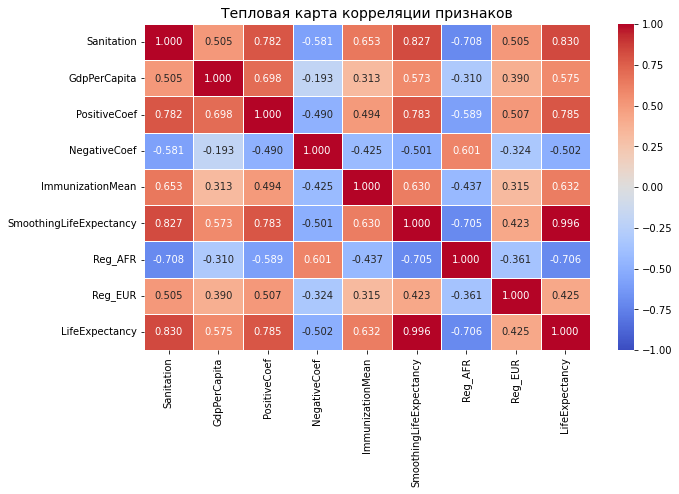

Посмотрим на пары признаков с коэффициентом корреляции больше, чем `0.7`

[(['Sanitation', 'PositiveCoef'], 0.78),
 (['Sanitation', 'SmoothingLifeExpectancy'], 0.83),
 (['Sanitation', 'Reg_AFR'], -0.71),
 (['Sanitation', 'LifeExpectancy'], 0.83),
 (['PositiveCoef', 'SmoothingLifeExpectancy'], 0.78),
 (['PositiveCoef', 'LifeExpectancy'], 0.79),
 (['SmoothingLifeExpectancy', 'LifeExpectancy'], 1.0),
 (['Reg_AFR', 'LifeExpectancy'], -0.71)]

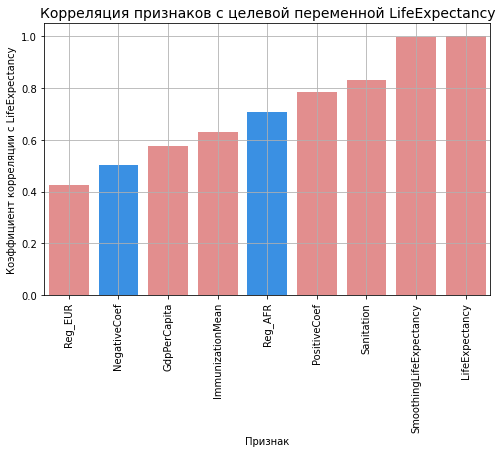

In [27]:
# Оставим в тренировочных данных оптимальные признаки
train_data_optimal = extract_optimal_features(train_data)

# Посмотрим на их корреляцию друг с другом и с целевой переменной
display_fields_correlation(
    train_data_optimal,
    matrix_figsize=(10, 6),
    barplot_figsize=(8, 5)
)

В данных все же остались мультиколлинеарные признаки.\
Но если их убрать, то значение метрики заметно снижается.\
И коэффициенты линейной регрессии выглядят устойчивыми.

In [28]:
# Оставим в тренировочных и тестовых данных оптимальные признаки
train_data = extract_optimal_features(train_data)
test_data = extract_optimal_features(test_data)

# Разделим предикторы и таргет
X_train = train_data.drop(columns=[F.LifeExpectancy.value])
X_test = test_data.drop(columns=[F.LifeExpectancy.value])

y_train = train_data[F.LifeExpectancy.value]
y_test = test_data[F.LifeExpectancy.value]

# Перед масштабированием данных сохраним имена столбцов и индексы
columns = list(X_train.columns)
index_train = X_train.index
index_test = X_test.index

# Инициализируем нормализатор MinMaxScaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)

# Масштабируем данные
X_train = mm_scaler.transform(X_train)
# Добавим имена столбцов и индексы, которые потерялись при преобразовании
X_train = pd.DataFrame(X_train, columns=columns, index=index_train)

X_test = mm_scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

Посмотрим на характеристики распределения предикторов.

In [29]:
X_test.describe()

,Sanitation,GdpPerCapita,PositiveCoef,NegativeCoef,ImmunizationMean,SmoothingLifeExpectancy,Reg_AFR,Reg_EUR
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,0.753130,0.111969,0.557190,0.663535,0.840328,0.756278,0.254144,0.276243
std,0.284264,0.158217,0.205648,0.189130,0.171542,0.152213,0.435780,0.447551
min,0.057196,0.000813,0.000000,0.000000,0.197368,0.318538,0.000000,0.000000
25%,0.507870,0.015352,0.400333,0.551347,0.771930,0.642568,0.000000,0.000000
50%,0.888386,0.044275,0.567378,0.660009,0.903509,0.782115,0.000000,0.000000
75%,0.978809,0.136843,0.675974,0.822480,0.964912,0.863595,1.000000,1.000000
max,1.000000,0.945186,1.000000,1.000000,1.000000,1.004312,1.000000,1.000000


In [30]:
X_test.describe()

,Sanitation,GdpPerCapita,PositiveCoef,NegativeCoef,ImmunizationMean,SmoothingLifeExpectancy,Reg_AFR,Reg_EUR
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,0.753130,0.111969,0.557190,0.663535,0.840328,0.756278,0.254144,0.276243
std,0.284264,0.158217,0.205648,0.189130,0.171542,0.152213,0.435780,0.447551
min,0.057196,0.000813,0.000000,0.000000,0.197368,0.318538,0.000000,0.000000
25%,0.507870,0.015352,0.400333,0.551347,0.771930,0.642568,0.000000,0.000000
50%,0.888386,0.044275,0.567378,0.660009,0.903509,0.782115,0.000000,0.000000
75%,0.978809,0.136843,0.675974,0.822480,0.964912,0.863595,1.000000,1.000000
max,1.000000,0.945186,1.000000,1.000000,1.000000,1.004312,1.000000,1.000000


Остались необходимые масштабированные признаки.

## Линейная регрессия

Теперь применим модель линейной регрессии.

In [31]:
# Начинаем замерять время выполнения
start = time.time()

# Создаём объект класса LinearRegression
linear_regression_model = LinearRegression()

# Обучаем модель
linear_regression_model.fit(X_train, y_train) 

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Получаем предсказание
y_test_pred = linear_regression_model.predict(X_test)
y_train_pred = linear_regression_model.predict(X_train)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)
# Метрика MAE для тренировочной выборки
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'LinearRegression',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00


Нам удалось улучшить метрику по сравнению с полученной путем экспоненциального сглаживания.

In [32]:
print('Свободный коэффициент линейной регрессии регрессии:')
print(linear_regression_model.intercept_)

print()

print('Коэффициенты линейной регрессии:')
print(linear_regression_model.coef_)

Свободный коэффициент линейной регрессии регрессии:
36.61790167033375

Коэффициенты линейной регрессии:
[ 2.75778987e-01  2.10216129e-01  3.73466052e-01  1.02936757e-01
  2.93073442e-01  4.65498390e+01 -1.35197595e-01 -1.00251934e-02]


Коэффициенты линейной регрессии не очень большие и не очень маленькие.\
Что говорит об устойчивости модели.

> Практика показала, что модели, основанные на деревьях решений, \
показывают на этих данных не очень хорошие результаты. \
И не сильно улучшают метрику по сравнению с результатом экспоненциального сглаживания. \
Поэтому сосредоточимся на моделях линейной регрессии, которые все же дают улучшение метрики.

## Полиномиальная регрессия 2-й степени

In [33]:
# Создаём генератор полиномиальных признаков
polynomial_features_generator2 = PolynomialFeatures(degree=2, include_bias=False)
# Обучаем его
polynomial_features_generator2.fit(X_train)

# Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly2 = polynomial_features_generator2.transform(X_train)
# Генерируем полиномиальные признаки для тестовой выборки
X_test_poly2 = polynomial_features_generator2.transform(X_test)

# Посмотрим на количество созданных признаков
print('Количество созданных признаков: ', X_train_poly2.shape[1])

Количество созданных признаков:  44


In [34]:
# Начинаем замерять время выполнения
start = time.time()

# Создаём объект класса LinearRegression
linear_regression_poly2_model = LinearRegression()

# Обучаем модель
linear_regression_poly2_model.fit(X_train_poly2, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание 
y_test_pred = linear_regression_poly2_model.predict(X_test_poly2)
y_train_pred = linear_regression_poly2_model.predict(X_train_poly2)

# Метрики MAE
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'LinearRegression poly 2',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00


Метрика не улучшилась.

In [35]:
print('Свободный коэффициент линейной регрессии регрессии:')
print(linear_regression_poly2_model.intercept_)

print()

print('Коэффициенты линейной регрессии:')
print(linear_regression_poly2_model.coef_)

Свободный коэффициент линейной регрессии регрессии:
41.90977074427475

Коэффициенты линейной регрессии:
[ 1.16920924  5.73489592  2.75295311 -2.04958042  1.48972699 29.59228385
 -1.19577839  0.26771383 -1.60115727 -1.1041062   2.9733917  -0.44317948
  0.73676315 -0.86896574 -1.5107573   0.27901297  0.03617962  0.37261827
  0.47356742  0.87760298 -7.13196449  3.26807921  0.44457169  0.40664182
  1.17042749 -1.16622749 -6.30207094 -1.86916971 -0.70353788  0.06472276
  3.91130154 -2.27773515  0.08826267 -0.51096289 -0.78192345 -2.23064321
 -3.1000433  -1.04837413 16.32433449  9.78493532  1.10865181 -1.19577839
  0.          0.26771383]


Коэффициенты не очень большие и не очень маленькие. \
Можно предположить, что модель устойчива.

## Полиномиальная регрессия 2-й степени с L1 регуляризацией

In [36]:
# Начинаем замерять время выполнения
start = time.time()

# Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_poly2_model = Lasso(alpha=0.001, max_iter=10000, random_state=RANDOM_STATE)

# Обучаем модель
lasso_poly2_model.fit(X_train_poly2, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание 
y_test_pred = lasso_poly2_model.predict(X_test_poly2)
y_train_pred = lasso_poly2_model.predict(X_train_poly2)

# Метрика MAE 
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'Lasso poly 2',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00
Lasso poly 2,0.554391,0.281072,00:00:00


Метрика немного улучшилась по сравнению с экспоненциальным сглаживанием.\
Но линейная регрессия лучше.

In [37]:
print('Свободный коэффициент линейной регрессии регрессии:')
print(lasso_poly2_model.intercept_)

print()

print('Коэффициенты линейной регрессии:')
print(lasso_poly2_model.coef_)

Свободный коэффициент линейной регрессии регрессии:
40.89117681968398

Коэффициенты линейной регрессии:
[ 3.78125063e-01 -0.00000000e+00  1.10325007e-01 -7.39377203e-01
  5.77104105e-02  3.54064854e+01 -1.73457952e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -5.82559057e-01  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -1.08572415e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -2.75416520e-01  1.21426903e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -1.10112182e+00 -3.48209125e-02  7.58064339e+00  4.49062573e+00
  0.00000000e+00 -4.72818047e-03  0.00000000e+00  0.00000000e+00]


Коэффициенты опять же не слишком большие и не слишком маленкие.\
Что говорит об устойчивости модели.\
Некоторые коэффициенты обнулились, что характерно для L1-регуляризации.

## Полиномиальная регрессия 3-й степени с L1 регуляризацией

In [38]:
# Создаём генератор полиномиальных признаков
polynomial_features_generator3 = PolynomialFeatures(degree=3, include_bias=False)
# Обучаем его
polynomial_features_generator3.fit(X_train)

# Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly3 = polynomial_features_generator3.transform(X_train)

# Генерируем полиномиальные признаки для тестовой выборки
X_test_poly3 = polynomial_features_generator3.transform(X_test)

# Посмотрим на количество созданных признаков
print('Количество созданных признаков: ', X_train_poly3.shape[1])

Количество созданных признаков:  164


In [39]:
# Начинаем замерять время выполнения
start = time.time()

# Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_poly3_model = Lasso(alpha=0.002, max_iter=10000, random_state=RANDOM_STATE)

# Обучаем модель
lasso_poly3_model.fit(X_train_poly3, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание 
y_test_pred = lasso_poly3_model.predict(X_test_poly3)
y_train_pred = lasso_poly3_model.predict(X_train_poly3)

# Метрика MAE 
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'Lasso poly 3',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00
Lasso poly 2,0.554391,0.281072,00:00:00
Lasso poly 3,0.553813,0.273795,00:00:00


Немного улучшили метрику по сравнению с предыдущей моделью.

In [40]:
print('Свободный коэффициент линейной регрессии регрессии:')
print(lasso_poly3_model.intercept_)

print()

print('Коэффициенты линейной регрессии:')
print(lasso_poly3_model.coef_)

Свободный коэффициент линейной регрессии регрессии:
39.53616713088263

Коэффициенты линейной регрессии:
[ 2.58381651e-01 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  5.79349985e-01  3.80622966e+01 -1.50830664e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  5.78027457e-02  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.49163467e-02 -0.00000000e+00  6.07231678e+00  1.90182460e+00
  0.00000000e+00 -1.31192174e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0

Есть предположение, что модель неустойчива, так как некоторые коэффициенты имеют степень $10^{-2} - 10^{-2}$.\
Некоторые коэффициенты обнулились, что характерно для L1-регуляризации.

## Бэггинг

Попробуем использовать бэггинг для уже испробованных выше моделей.

### Бэггинг линейных регрессий

In [41]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
bg_model = BaggingRegressor(
    estimator=LinearRegression(),
    n_estimators=4500,
    random_state=RANDOM_STATE,
)
# Обучаем
bg_model.fit(X_train, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание 
y_test_pred = bg_model.predict(X_test)
y_train_pred = bg_model.predict(X_train)

# Метрика MAE
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'Bagging LinearRegression',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00
Lasso poly 2,0.554391,0.281072,00:00:00
Lasso poly 3,0.553813,0.273795,00:00:00
Bagging LinearRegression,0.550137,0.261237,00:00:09


Метрика сравнима с обычной линейной регрессией.

### Бэггинг полиномиальных регрессий 2-й степени с L1-регуляризацией

In [42]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
bg_model = BaggingRegressor(
    estimator=Lasso(alpha=0.001, max_iter=10000, random_state=RANDOM_STATE),
    n_estimators=1500,
    random_state=RANDOM_STATE,
)

# Обучаем
bg_model.fit(X_train_poly2, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание 
y_test_pred = bg_model.predict(X_test_poly2)
y_train_pred = bg_model.predict(X_train_poly2)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'Bagging Lasso poly 2',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00
Lasso poly 2,0.554391,0.281072,00:00:00
Lasso poly 3,0.553813,0.273795,00:00:00
Bagging LinearRegression,0.550137,0.261237,00:00:09
Bagging Lasso poly 2,0.553561,0.278052,00:01:22


Метрика немного лучше, чем у просто полиномиальной регрессии 2-й степени с L1-регуляризацией.

## Бустинг

Применим адаптивный бустинг с помощью  `AdaBoostRegressor` на основе построенных ранее моделей.

### Бустинг линейных регрессий

In [43]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
abr_model = AdaBoostRegressor(
    base_estimator=LinearRegression(),
    learning_rate=0.0002, 
    random_state=RANDOM_STATE
)
# Обучаем
abr_model.fit(X_train, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание 
y_test_pred = abr_model.predict(X_test)
y_train_pred = abr_model.predict(X_train)

# Метрика MAE 
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'AdaBoost LinearRegression',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00
Lasso poly 2,0.554391,0.281072,00:00:00
Lasso poly 3,0.553813,0.273795,00:00:00
Bagging LinearRegression,0.550137,0.261237,00:00:09
Bagging Lasso poly 2,0.553561,0.278052,00:01:22


Метрика сравнима с бэггингом линейных регрессий.

### Бустинг полиномиальных регрессий 2-й степени с L1-регуляризацией

In [44]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
abr_model = AdaBoostRegressor(
    base_estimator=Lasso(alpha=0.001, max_iter=10000, random_state=RANDOM_STATE),
    learning_rate=0.0005, 
    random_state=RANDOM_STATE
)
# Обучаем
abr_model.fit(X_train_poly2, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание 
y_test_pred = abr_model.predict(X_test_poly2)
y_train_pred = abr_model.predict(X_train_poly2)

# Метрика MAE 
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'AdaBoost Lasso poly 2',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00
Lasso poly 2,0.554391,0.281072,00:00:00
Lasso poly 3,0.553813,0.273795,00:00:00
Bagging LinearRegression,0.550137,0.261237,00:00:09
Bagging Lasso poly 2,0.553561,0.278052,00:01:22


Метрика сравнима с бэггингом полиномиальных регрессий 2-й степени с L1-регуляризацией.\
Но по времени считается намного быстрее.

### Бустинг полиномиальных регрессий 3-й степени с L1-регуляризацией

In [45]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем модель
abr_model = AdaBoostRegressor(
    base_estimator=Lasso(alpha=0.0019, max_iter=10000, random_state=RANDOM_STATE),
    learning_rate=0.0006,
    random_state=RANDOM_STATE
)
# Обучаем
abr_model.fit(X_train_poly3, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание 
y_test_pred = abr_model.predict(X_test_poly3)
y_train_pred = abr_model.predict(X_train_poly3)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'AdaBoost Lasso poly 3',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00
Lasso poly 2,0.554391,0.281072,00:00:00
Lasso poly 3,0.553813,0.273795,00:00:00
Bagging LinearRegression,0.550137,0.261237,00:00:09
Bagging Lasso poly 2,0.553561,0.278052,00:01:22


Метрика сравнима с обычной линейной регрессией.

## Стекинг

Применим стекинг на основе лучших из полученных моделей.

In [46]:
# Отсортируем модели по полученной метрике
display_model_results(True)

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
AdaBoost LinearRegression,0.549309,0.257224,00:00:00
LinearRegression,0.55013,0.261232,00:00:00
Bagging LinearRegression,0.550137,0.261237,00:00:09
AdaBoost Lasso poly 3,0.551846,0.271939,00:00:08
AdaBoost Lasso poly 2,0.552851,0.276693,00:00:02
Bagging Lasso poly 2,0.553561,0.278052,00:01:22
ExponentialSmoothing,0.553576,0.247689,00:00:01
Lasso poly 3,0.553813,0.273795,00:00:00
Lasso poly 2,0.554391,0.281072,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00


Возьмем модели, в которых использовали регрессии без полиномиальных признаков.\
Их три - это адаптивный бустинг, бэггинг и обычная линейная регрессия.

In [47]:
# Начинаем замерять время выполнения
start = time.time()

abr_model = AdaBoostRegressor(
    base_estimator=LinearRegression(),
    learning_rate=0.0002, 
    random_state=RANDOM_STATE
)
bg_model = BaggingRegressor(
    estimator=LinearRegression(),
    n_estimators=4500,
    random_state=RANDOM_STATE,
)
linear_regression_model = LinearRegression()

estimators = [
    ('abr_model', abr_model),
    ('bg_model', bg_model),
    ('linear_regression_model', linear_regression_model),
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

stacking_model.fit(X_train, y_train)

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Делаем предсказание 
y_test_pred = stacking_model.predict(X_test)
y_train_pred = stacking_model.predict(X_train)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Запомним результаты модели
save_model_result(
    'Stacking',
    mae_test,
    mae_train,
    exec_time,
)

# Выведем результаты
display_model_results()

**Значения метрики MAE для разных моделей**

,MaeTest,MaeTrain,ModelFitTime
ExponentialSmoothing,0.553576,0.247689,00:00:01
ARIMA,0.628497,4.125566,00:00:11
ARIMA with pmdarima,0.682415,None,00:01:07
ARIMAX,1.631312,None,00:00:06
LinearRegression,0.55013,0.261232,00:00:00
LinearRegression poly 2,0.604918,0.305937,00:00:00
Lasso poly 2,0.554391,0.281072,00:00:00
Lasso poly 3,0.553813,0.273795,00:00:00
Bagging LinearRegression,0.550137,0.261237,00:00:09
Bagging Lasso poly 2,0.553561,0.278052,00:01:22


Метрика не стала лучше, чем у моделей, на которых основан стекинг.

## Выводы

> Остановимся на модели обычной линейной регрессии.\
Она немного улучшает метрику экспоненциального сглаживания, \
и ее метрика незначительно отличается от более сложных моделей.
>
> Также у более сложных моделей полиномиальных регрессий может проявиться следующий артефакт.\
Если увеличить значения предикторов, имеющих положительную корреляцию с целевой переменной \
(например, ВВП на душу населения, иммунизацию и др.), \
то значение целевой переменной может не увеличится (как ожидается), а уменьшиться.\
Это связано с комбинированными коэффициентами, в которые входят отрицательные значения.
>
> Поэтому  для данного случая наиболее подходит обычная линейная регрессия.

**Немного рассуждений о том, почему не удается значительно улучшить результат экспоненциального сглаживания.**

На графиках прогноза, сделанного с помощью экспоненциального сглаживания [05_exp_smoothing.ipynb](../04_feature_inginiring/05_exp_smoothing.ipynb) \
можно увидеть, что за 3 года, для которых делается предсказание (2018-2020), \
есть скачки целевой переменной, которые не объясняются предикторами и сильно отходят от сглаженных значений.\
Скорее всего эти скачки связаны с COVID-19, но предвидеть на момент 2017 г. его вряд ли было возможно по каким-то общедоступным данным.\
Исследование этих скачков показывает, что они не объясняются имеющимися предикторами \
(здесь это исследование не приводится по причине большого объема проекта).

За счет этих скачков, которые отходят от сглаживания и не объясняются предикторами, и получается устойчивое значение ошибки.

Короткие временные ряды, если они предсказываются на небольшой промежуток, лучше всего прогнозируются, пожалуй, с помощью сглаживания.\
И этот признак больше всего коррелирует с целевой переменной и забивает собой другие признаки.\
Но без него результат будет хуже.

Поэтому остановимся на достигнутом результате - экспоненциальное сглаживание плюс линейная регрессия.